В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [60]:
import pandas as pd
train_df = pd.read_csv('train.csv')

In [61]:
train_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15807989.0,Ch'iu,585.0,France,Male,33.0,3.0,0.00,1.0,1.0,0.0,54191.38,0.0
14996,14996,15731781.0,Ch'ang,678.0,France,Male,34.0,6.0,0.00,2.0,1.0,1.0,53437.10,0.0
14997,14997,15667093.0,Goliwe,678.0,France,Female,54.0,4.0,0.00,1.0,1.0,0.0,147720.29,1.0
14998,14998,15732644.0,Fanucci,705.0,Spain,Female,40.0,7.0,0.00,2.0,1.0,0.0,149550.95,0.0


In [62]:
from sklearn.model_selection import train_test_split
target = train_df['Exited']
features = train_df.drop(columns=['Exited'])

features_train, features_val, target_train,target_val  = train_test_split(features, target, test_size=0.2, random_state=42,stratify=target )


In [63]:
print(target_train.value_counts(normalize=True).round(2))
print(target_val.value_counts(normalize=True).round(2))

Exited
0.0    0.8
1.0    0.2
Name: proportion, dtype: float64
Exited
0.0    0.8
1.0    0.2
Name: proportion, dtype: float64


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [64]:
input_cols = list(features)
target_col = 'Exited'

In [65]:
train_inputs = features_train[input_cols].copy()
train_targets = target_train.copy()

val_inputs = features_val[input_cols].copy()
val_targets = target_val.copy()

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [66]:
import numpy as np
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [67]:
numeric_cols

['id',
 'CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [68]:
categorical_cols

['Surname', 'Geography', 'Gender']

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [69]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


У вхідних даних не було колонок з пустими значеннями тому заповнювати нічого не треба

In [70]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [71]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [72]:
train_inputs[numeric_cols].describe().round(2)

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,0.50,0.99,0.54,0.35,0.50,0.21,0.20,0.79,0.49,0.59
std,0.29,0.01,0.17,0.15,0.28,0.29,0.18,0.41,0.50,0.23
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.25,0.99,0.41,0.25,0.30,0.00,0.00,1.00,0.00,0.42
50%,0.50,0.99,0.55,0.34,0.50,0.00,0.33,1.00,0.00,0.62
75%,0.75,1.00,0.66,0.43,0.70,0.52,0.33,1.00,1.00,0.78
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [73]:
train_inputs[categorical_cols].nunique()

,0
Surname,732
Geography,3
Gender,2


Дані у колонці Surname не можуть вплинути ніяк на розрахунок тому видаляємо їх

In [74]:
categorical_cols.remove('Surname')

In [75]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [76]:
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [77]:
encoder.categories_

[array(['France', 'Germany', 'Spain'], dtype=object),
 array(['Female', 'Male'], dtype=object)]

In [78]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']


In [79]:
encoder.transform(train_inputs[categorical_cols])[:10]

array([[1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0.]])

In [80]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [81]:
display(train_inputs.head())
display(val_inputs.head())

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,0.478699,0.988516,Mays,0.599045,France,Male,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,0.0,1.0
10393,0.692913,0.984351,Ch'eng,0.603819,France,Female,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,1.0,0.0
80,0.005334,0.997112,Ch'in,0.653938,Germany,Male,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,0.0,1.0
3365,0.224348,0.997533,K?,0.568019,Spain,Male,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,1.0,0.0,1.0
12236,0.815788,0.987805,Trevisani,0.658711,France,Male,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,0.0,0.0,1.0


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
6490,0.432696,0.998500,Pirozzi,0.675418,Germany,Male,0.500000,0.1,0.551870,1.000000,1.0,1.0,0.364704,0.0,1.0,0.0,0.0,1.0
3646,0.243083,0.986066,Ritchie,0.386635,France,Male,0.410714,0.5,0.000000,0.333333,1.0,1.0,0.190942,1.0,0.0,0.0,0.0,1.0
5306,0.353757,0.998048,Hs?eh,0.715990,France,Female,0.357143,0.2,0.000000,0.333333,0.0,1.0,0.584853,1.0,0.0,0.0,1.0,0.0
652,0.043470,0.999135,Onio,0.577566,France,Female,0.446429,0.4,0.742441,0.000000,0.0,1.0,0.558109,1.0,0.0,0.0,1.0,0.0
2627,0.175145,0.996960,Genovesi,0.589499,Spain,Female,0.214286,0.4,0.000000,0.333333,1.0,0.0,0.718420,0.0,0.0,1.0,1.0,0.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [82]:
!pip install pyarrow --quiet

In [83]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')

In [84]:
%%time
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')

CPU times: user 8.57 ms, sys: 75 µs, total: 8.65 ms
Wall time: 10.1 ms


In [85]:
!ls

log_reg.joblib		test.csv	       val_inputs.parquet
sample_data		train.csv	       val_targets.parquet
sample_submission.csv	train_inputs.parquet
submission_log_reg.csv	train_targets.parquet


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [86]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]

In [87]:
X_train

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,0.478699,0.988516,0.599045,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,0.0,1.0
10393,0.692913,0.984351,0.603819,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,1.0,0.0
80,0.005334,0.997112,0.653938,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,0.0,1.0
3365,0.224348,0.997533,0.568019,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,1.0,0.0,1.0
12236,0.815788,0.987805,0.658711,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9493,0.632909,0.992666,0.482100,0.267857,0.4,0.000000,0.333333,0.0,0.0,0.617686,1.0,0.0,0.0,1.0,0.0
8463,0.564238,0.997382,0.577566,0.392857,0.1,0.000000,0.000000,1.0,1.0,0.239129,1.0,0.0,0.0,1.0,0.0
8143,0.542903,0.983807,0.453461,0.196429,0.8,0.000000,0.333333,1.0,1.0,0.667682,1.0,0.0,0.0,0.0,1.0
11512,0.767518,0.991483,0.379475,0.428571,0.7,0.000000,0.333333,0.0,0.0,0.363197,0.0,0.0,1.0,0.0,1.0


In [88]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear')

In [89]:
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

In [90]:
train_preds = model.predict(X_train)
train_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [91]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.98531436, 0.01468564],
       [0.72601231, 0.27398769],
       [0.87426825, 0.12573175],
       ...,
       [0.99268932, 0.00731068],
       [0.83136714, 0.16863286],
       [0.94944151, 0.05055849]])

In [92]:
train_targets.value_counts(normalize=True)

,proportion
Exited,
0.0,0.7965
1.0,0.2035


In [93]:
from sklearn.metrics import accuracy_score

In [94]:
train_accuracy = accuracy_score(train_targets, train_preds)
train_accuracy*100

87.41666666666667

In [95]:
val_preds = model.predict(X_val)

In [96]:
val_accuracy = accuracy_score(val_targets, val_preds)
val_accuracy*100

87.16666666666667

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [97]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

In [98]:
confusion_matrix(train_targets, train_preds)

array([[9178,  380],
       [1130, 1312]])

In [99]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 87.42%


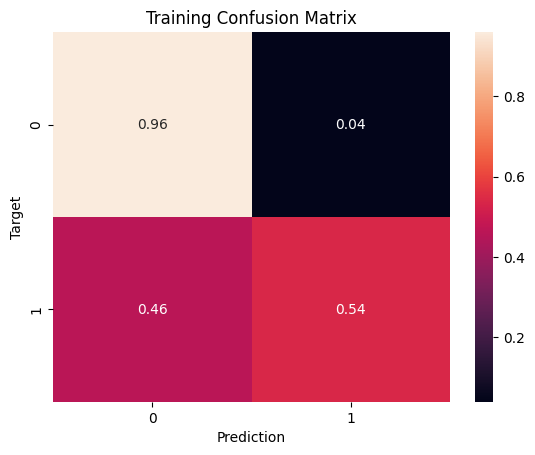

In [100]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')

Accuracy: 87.17%


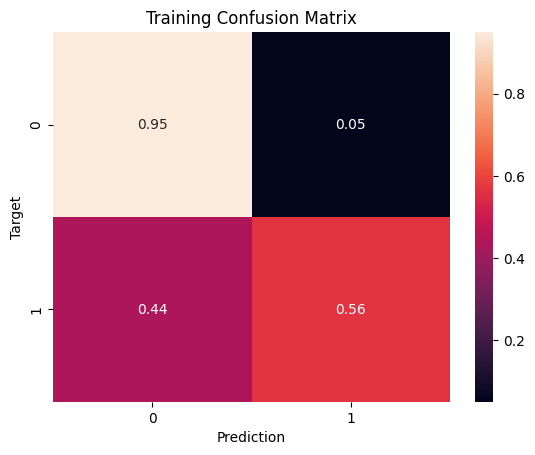

In [101]:
val_preds = predict_and_plot(X_val, val_targets, 'Training')

In [102]:
def get_f1_score(inputs, targets, name=''):
  preds = model.predict(inputs)

  f1_score_ = f1_score(targets, preds, pos_label=1)
  print(f"F1 score {name}: {f1_score_:.2f}")

get_f1_score(X_train, train_targets, 'Training')
get_f1_score(X_val, val_targets, 'Validation')

F1 score Training: 0.63
F1 score Validation: 0.64


In [103]:
from sklearn.metrics import roc_curve, auc

def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Training: 0.88


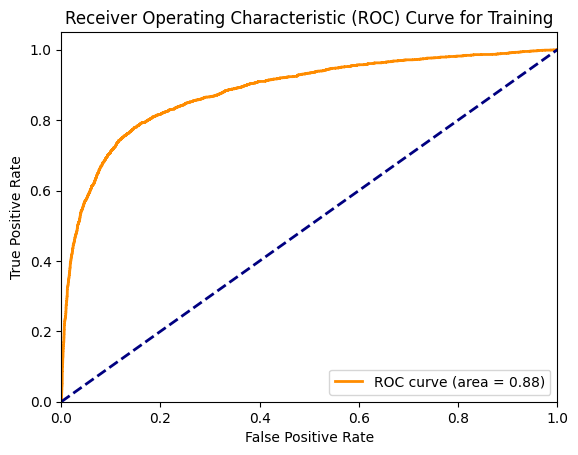

AUROC for Validation: 0.88


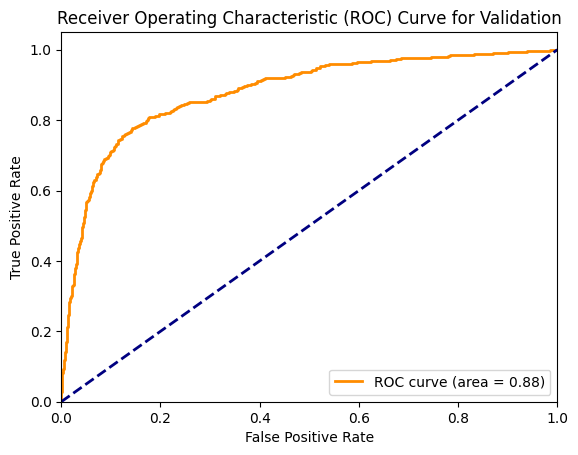

In [104]:
compute_auroc_and_build_roc(X_train, train_targets, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, 'Validation')

Модель є хорошою так як Accuracy для тренувальної та валідаційної моделі становить 87%, AUROC для обох моделей на рівні 88%, F1 для тренувальної моделістановить 63%. для валідаційної 64%

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [105]:
print(target_train.value_counts(normalize=True).round(2))

Exited
0.0    0.8
1.0    0.2
Name: proportion, dtype: float64


Найбільше людей зі значенням Exited = 0 (не залишили банк)

In [106]:
train_preds = np.full(len(train_targets), 0)
val_preds = np.full(len(val_targets),0)

train_accuracy = accuracy_score(train_targets, train_preds)
val_accuracy = accuracy_score(val_targets, val_preds)
train_accuracy, val_accuracy

(0.7965, 0.7966666666666666)

Accuracy модель яка завжи передбачає що клієнт залишиться становить 80%, оригінальна становить 87% це значить що модель хороша так як виявила вплив показників на цільове значення, а не вгадує результат.

---



9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [107]:
import joblib

In [108]:
log_reg  = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [109]:
joblib.dump(log_reg, 'log_reg.joblib')

['log_reg.joblib']

In [110]:
model_2 = joblib.load('log_reg.joblib')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [111]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [112]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, train_df[:5])

array([0.00642689, 0.0362191 , 0.36841859, 0.37559672, 0.97555155])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [118]:
test_raw_df = pd.read_csv('test.csv')

In [119]:
test_raw_df= test_raw_df.drop(columns=['Surname'], errors='ignore')

In [120]:
test_probs = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)

In [121]:
test_raw_df['Exited'] = test_probs

In [122]:
test_probs

array([0.07648385, 0.03580677, 0.15501115, ..., 0.01903656, 0.15940269,
       0.09548605])

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [123]:
submission_df = pd.read_csv('sample_submission.csv')

In [124]:
submission_df['Exited'] = test_probs

In [125]:
print(submission_df.head())

      id    Exited
0  15000  0.076484
1  15001  0.035807
2  15002  0.155011
3  15003  0.195721
4  15004  0.056464


In [126]:
submission_df.to_csv('submission_log_reg.csv', index=False)